## **Import Libraries**

In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten , BatchNormalization


from tensorflow.keras.utils import to_categorical

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns # for confusion matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import json
import os
import numpy as np 

## **Load Dataset**

In [16]:
(x_train , y_train) , (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

In [17]:
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


## **Visualization**

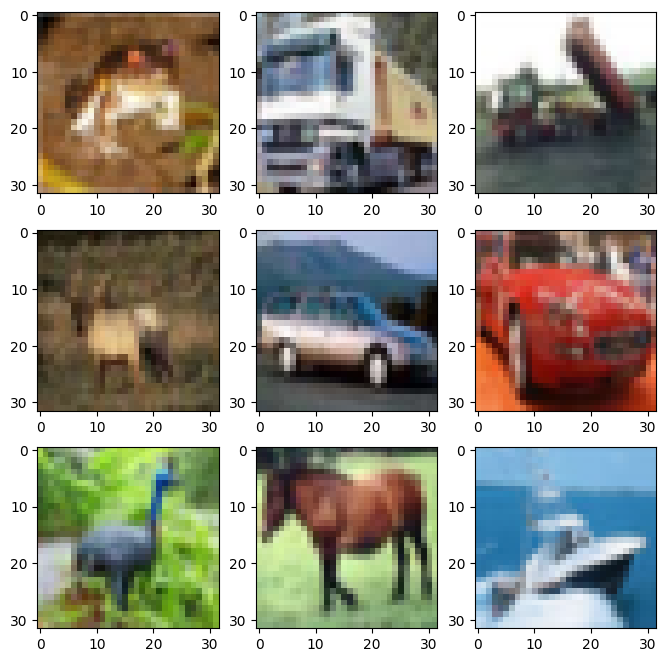

In [18]:
# create a grid of 3x3 images
plt.figure(figsize=(8,8))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    img = x_train[i]
    plt.imshow(img)
    
# show the plot
plt.show()

## **Preprocess and Splitting**

In [19]:
def normalize(x):
    x = x.astype('float32')
    x = x/255.0
    return x

datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
)

### Split Data

In [20]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0) # seed for fixing the x_test and y_test

In [21]:
x_train = normalize(x_train)
x_test = normalize(x_test)
x_val = normalize(x_val)

y_train = tf.keras.utils.to_categorical(y_train , 10) # one hot encoding
y_test = tf.keras.utils.to_categorical(y_test , 10)
y_val  = tf.keras.utils.to_categorical(y_val , 10)

datagen.fit(x_train)

In [22]:
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(5000, 10)
(5000, 10)


## **Model**

In [23]:
weight_decay = 1e-4
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, name="outputs")
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,201,418 (8.40 MB)

 Trainable params: 2,199,114 (8.39 MB)

 Non-trainable params: 2,304 (9.00 KB)

### Training

In [24]:
opt =    tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

model.compile(
    optimizer=opt, 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [25]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', 
                                patience=10,
                                cooldown=1,
                                verbose=1),
              EarlyStopping(monitor='val_loss',
                            min_delta=1e-4,
                            patience=15)]

In [26]:
epoch = 50
history = model.fit(datagen.flow(x_train , y_train , batch_size = 64), epochs = epoch, steps_per_epoch=len(x_train)//64, validation_data = (x_val , y_val) , verbose = 1, callbacks=callbacks)

Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 402s 503ms/step - accuracy: 0.3473 - loss: 2.1433 - val_accuracy: 0.5810 - val_loss: 1.2588 - learning_rate: 0.0010
Epoch 2/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:45 519ms/step - accuracy: 0.5312 - loss: 1.4422

2024-06-05 14:08:51.941013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib64/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5312 - loss: 1.4422 - val_accuracy: 0.5934 - val_loss: 1.2390 - learning_rate: 0.0010
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 391s 501ms/step - accuracy: 0.5913 - loss: 1.2414 - val_accuracy: 0.6614 - val_loss: 1.0914 - learning_rate: 0.0010
Epoch 4/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:50 527ms/step - accuracy: 0.6406 - loss: 1.0102

2024-06-05 14:15:34.315722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6406 - loss: 1.0102 - val_accuracy: 0.6650 - val_loss: 1.0886 - learning_rate: 0.0010
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 365s 466ms/step - accuracy: 0.6758 - loss: 1.0240 - val_accuracy: 0.6758 - val_loss: 1.0861 - learning_rate: 0.0010
Epoch 6/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:24 492ms/step - accuracy: 0.6562 - loss: 1.0596

2024-06-05 14:21:50.112948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6562 - loss: 1.0596 - val_accuracy: 0.6686 - val_loss: 1.1096 - learning_rate: 0.0010
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 394s 504ms/step - accuracy: 0.7211 - loss: 0.9279 - val_accuracy: 0.6774 - val_loss: 1.0572 - learning_rate: 0.0010
Epoch 8/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:26 496ms/step - accuracy: 0.7188 - loss: 0.8907

2024-06-05 14:28:35.379709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7188 - loss: 0.8907 - val_accuracy: 0.6840 - val_loss: 1.0328 - learning_rate: 0.0010
Epoch 9/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 389s 451ms/step - accuracy: 0.7461 - loss: 0.8791 - val_accuracy: 0.7492 - val_loss: 0.9141 - learning_rate: 0.0010
Epoch 10/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:31 502ms/step - accuracy: 0.8750 - loss: 0.5833

2024-06-05 14:35:15.531753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8750 - loss: 0.5833 - val_accuracy: 0.7470 - val_loss: 0.9156 - learning_rate: 0.0010
Epoch 11/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 346s 443ms/step - accuracy: 0.7645 - loss: 0.8485 - val_accuracy: 0.7128 - val_loss: 1.0720 - learning_rate: 0.0010
Epoch 12/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:29 500ms/step - accuracy: 0.6562 - loss: 1.0427

2024-06-05 14:41:22.930956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6562 - loss: 1.0427 - val_accuracy: 0.7094 - val_loss: 1.0926 - learning_rate: 0.0010
Epoch 13/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 356s 455ms/step - accuracy: 0.7768 - loss: 0.8262 - val_accuracy: 0.8086 - val_loss: 0.7824 - learning_rate: 0.0010
Epoch 14/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:47 292ms/step - accuracy: 0.7656 - loss: 0.9927

2024-06-05 14:47:29.638142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7656 - loss: 0.9927 - val_accuracy: 0.8174 - val_loss: 0.7597 - learning_rate: 0.0010
Epoch 15/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 245s 314ms/step - accuracy: 0.7875 - loss: 0.8253 - val_accuracy: 0.7940 - val_loss: 0.8417 - learning_rate: 0.0010
Epoch 16/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:49 295ms/step - accuracy: 0.8125 - loss: 0.7898

2024-06-05 14:51:40.855336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8125 - loss: 0.7898 - val_accuracy: 0.7928 - val_loss: 0.8432 - learning_rate: 0.0010
Epoch 17/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 218s 279ms/step - accuracy: 0.7973 - loss: 0.8163 - val_accuracy: 0.6914 - val_loss: 1.2042 - learning_rate: 0.0010
Epoch 18/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:42 286ms/step - accuracy: 0.7344 - loss: 0.8895

2024-06-05 14:55:25.180742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7344 - loss: 0.8895 - val_accuracy: 0.6898 - val_loss: 1.2079 - learning_rate: 0.0010
Epoch 19/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 219s 280ms/step - accuracy: 0.8038 - loss: 0.8096 - val_accuracy: 0.7984 - val_loss: 0.8584 - learning_rate: 0.0010
Epoch 20/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:49 295ms/step - accuracy: 0.8281 - loss: 0.6794

2024-06-05 14:59:10.287891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8281 - loss: 0.6794 - val_accuracy: 0.7964 - val_loss: 0.8693 - learning_rate: 0.0010
Epoch 21/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 191s 244ms/step - accuracy: 0.8141 - loss: 0.7978 - val_accuracy: 0.8122 - val_loss: 0.8282 - learning_rate: 0.0010
Epoch 22/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:48 216ms/step - accuracy: 0.9531 - loss: 0.5713

2024-06-05 15:02:26.917607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9531 - loss: 0.5713 - val_accuracy: 0.8172 - val_loss: 0.8175 - learning_rate: 0.0010
Epoch 23/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8197 - loss: 0.7922 - val_accuracy: 0.7996 - val_loss: 0.8959 - learning_rate: 0.0010
Epoch 24/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:43 209ms/step - accuracy: 0.8125 - loss: 0.8133

2024-06-05 15:05:17.974858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8125 - loss: 0.8133 - val_accuracy: 0.8090 - val_loss: 0.8659 - learning_rate: 0.0010
Epoch 25/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 168s 214ms/step - accuracy: 0.8430 - loss: 0.7235 - val_accuracy: 0.8702 - val_loss: 0.6576 - learning_rate: 1.0000e-04
Epoch 26/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:38 204ms/step - accuracy: 0.7500 - loss: 0.9134

2024-06-05 15:08:09.055031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7500 - loss: 0.9134 - val_accuracy: 0.8706 - val_loss: 0.6566 - learning_rate: 1.0000e-04
Epoch 27/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 168s 215ms/step - accuracy: 0.8629 - loss: 0.6623 - val_accuracy: 0.8692 - val_loss: 0.6537 - learning_rate: 1.0000e-04
Epoch 28/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:43 209ms/step - accuracy: 0.8281 - loss: 0.6824

2024-06-05 15:11:00.665495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8281 - loss: 0.6824 - val_accuracy: 0.8692 - val_loss: 0.6537 - learning_rate: 1.0000e-04
Epoch 29/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 168s 215ms/step - accuracy: 0.8672 - loss: 0.6384 - val_accuracy: 0.8734 - val_loss: 0.6336 - learning_rate: 1.0000e-04
Epoch 30/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:41 208ms/step - accuracy: 0.8438 - loss: 0.5918

2024-06-05 15:13:51.948905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8438 - loss: 0.5918 - val_accuracy: 0.8738 - val_loss: 0.6334 - learning_rate: 1.0000e-04
Epoch 31/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8704 - loss: 0.6228 - val_accuracy: 0.8780 - val_loss: 0.6165 - learning_rate: 1.0000e-04
Epoch 32/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:43 210ms/step - accuracy: 0.9375 - loss: 0.4426

2024-06-05 15:16:42.975329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9375 - loss: 0.4426 - val_accuracy: 0.8782 - val_loss: 0.6167 - learning_rate: 1.0000e-04
Epoch 33/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8739 - loss: 0.6050 - val_accuracy: 0.8806 - val_loss: 0.5984 - learning_rate: 1.0000e-04
Epoch 34/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:39 205ms/step - accuracy: 0.8750 - loss: 0.5799

2024-06-05 15:19:33.979461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8750 - loss: 0.5799 - val_accuracy: 0.8808 - val_loss: 0.5979 - learning_rate: 1.0000e-04
Epoch 35/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 168s 215ms/step - accuracy: 0.8804 - loss: 0.5867 - val_accuracy: 0.8770 - val_loss: 0.6046 - learning_rate: 1.0000e-04
Epoch 36/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:44 211ms/step - accuracy: 0.8750 - loss: 0.5043

2024-06-05 15:22:25.302870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8750 - loss: 0.5043 - val_accuracy: 0.8770 - val_loss: 0.6048 - learning_rate: 1.0000e-04
Epoch 37/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8812 - loss: 0.5750 - val_accuracy: 0.8720 - val_loss: 0.6246 - learning_rate: 1.0000e-04
Epoch 38/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:44 211ms/step - accuracy: 0.9062 - loss: 0.5042

2024-06-05 15:25:16.067685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9062 - loss: 0.5042 - val_accuracy: 0.8716 - val_loss: 0.6247 - learning_rate: 1.0000e-04
Epoch 39/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8832 - loss: 0.5583 - val_accuracy: 0.8826 - val_loss: 0.5821 - learning_rate: 1.0000e-04
Epoch 40/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:38 204ms/step - accuracy: 0.8906 - loss: 0.5704

2024-06-05 15:28:06.826924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8906 - loss: 0.5704 - val_accuracy: 0.8826 - val_loss: 0.5826 - learning_rate: 1.0000e-04
Epoch 41/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8897 - loss: 0.5452 - val_accuracy: 0.8846 - val_loss: 0.5698 - learning_rate: 1.0000e-04
Epoch 42/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:41 207ms/step - accuracy: 0.9062 - loss: 0.5733

2024-06-05 15:30:57.431230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9062 - loss: 0.5733 - val_accuracy: 0.8846 - val_loss: 0.5696 - learning_rate: 1.0000e-04
Epoch 43/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8845 - loss: 0.5474 - val_accuracy: 0.8782 - val_loss: 0.5694 - learning_rate: 1.0000e-04
Epoch 44/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:44 210ms/step - accuracy: 0.8906 - loss: 0.4942

2024-06-05 15:33:48.002418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8906 - loss: 0.4942 - val_accuracy: 0.8792 - val_loss: 0.5695 - learning_rate: 1.0000e-04
Epoch 45/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8865 - loss: 0.5333 - val_accuracy: 0.8820 - val_loss: 0.5657 - learning_rate: 1.0000e-04
Epoch 46/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:40 206ms/step - accuracy: 0.8906 - loss: 0.5554

2024-06-05 15:36:38.856808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8906 - loss: 0.5554 - val_accuracy: 0.8814 - val_loss: 0.5652 - learning_rate: 1.0000e-04
Epoch 47/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 168s 214ms/step - accuracy: 0.8892 - loss: 0.5231 - val_accuracy: 0.8820 - val_loss: 0.5574 - learning_rate: 1.0000e-04
Epoch 48/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:44 211ms/step - accuracy: 0.9375 - loss: 0.4474

2024-06-05 15:39:29.940263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9375 - loss: 0.4474 - val_accuracy: 0.8820 - val_loss: 0.5578 - learning_rate: 1.0000e-04
Epoch 49/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8936 - loss: 0.5097 - val_accuracy: 0.8864 - val_loss: 0.5441 - learning_rate: 1.0000e-04
Epoch 50/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:43 209ms/step - accuracy: 0.8438 - loss: 0.7195

2024-06-05 15:42:20.947596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8438 - loss: 0.7195 - val_accuracy: 0.8864 - val_loss: 0.5441 - learning_rate: 1.0000e-04


## **Results and Save**

### **Results**

In [ ]:
def plot_results(model):
    epoch = max(
        [
            len(history.history[key]) for key in ["accuracy","val_accuracy","loss","val_loss"]
        ]
        )
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.savefig("Classification Accuracy")
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.savefig("Model loss")
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    
    Args:
    y_true (list or array): True labels.
    y_pred (list or array): Predicted labels.
    classes (list): List of class names for labeling the axes in the plot.
    cmap (matplotlib.colors.Colormap, optional): Colormap to be used for the plot. Defaults to plt.cm.Blues.
    
    Returns:
    None: Displays the confusion matrix.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model_performance(y_true, y_pred):
    """
    Evaluate model performance metrics including accuracy, precision, recall, and F1 score.
    
    Args:
    y_true (list or array): Actual true labels.
    y_pred (list or array): Predicted labels from the model.
    
    Returns:
    dict: A dictionary containing all the scores.
    """
    scores = {}
    scores['accuracy'] = accuracy_score(y_true, y_pred)
    scores['precision'] = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for unweighted mean
    scores['recall'] = recall_score(y_true, y_pred, average='macro')
    scores['f1_score'] = f1_score(y_true, y_pred, average='macro')
    
    return scores

In [ ]:
acc = model.evaluate(x_test , y_test)
print("test set loss : " , acc[0])
print("test set accuracy :", acc[1]*100)

In [ ]:
plot_results(model)

### Confusion Matrix

In [ ]:
# Calculate the confusion matrix
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Make predictions
y_pred = model.predict(x_test)
# Convert predictions from probabilities to labels if necessary
y_pred_labels = np.argmax(y_pred, axis=1)

# Assuming y_test is also in a one-hot encoded format, convert it to labels
y_true_labels = np.argmax(y_test, axis=1)
conf_matrix = plot_confusion_matrix(y_true_labels, y_pred_labels,class_names)


### Other Scores

In [ ]:
# Evaluate other performance metrics
performance_scores = evaluate_model_performance(y_true_labels, y_pred_labels)
print("Performance Scores:")
for score_name, score_value in performance_scores.items():
    print(f"{score_name.capitalize()}: {score_value}")

### Save

In [50]:
from random import randint
def saveModel(model, history: dict, dir_prefix: str = r"../NoteBook/Teacher", dir_output:str=r"Teacher-1"):
    """
    Creates a directory and saves the model in .h5 format, training history as a JSON file,
    and training and test datasets as .npy files.

    Args:
    model (tf.keras.Model): The trained Keras model to save.
    history (dict): Dictionary containing the training history.
    x_test, y_test, x_train, y_train (numpy.ndarray): Datasets to save.
    output_dir (str, optional): The directory to save all files. Defaults to "TeacherModel".

    Returns:
    bool: True if all files are saved successfully, False if an error occurs.
    """
    try:        
    # Create the directory if it does not exist
        dir_path = os.path.join(dir_prefix, dir_output)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            
        history_path = os.path.join(dir_path, "history.json")
        with open(history_path, 'w') as f:
            f.write(json.dumps(history,indent=4))
            f.close()

        model_path = os.path.join(dir_path, "model.keras")
        model.save(model_path)
        

        return True
    except Exception as e:
        print(type(e))
        print(f"An error occurred: {e}")
        
        return False


In [51]:
# print(history.history)
index = 7
print(saveModel(model,history.history,dir_output=f"Teacher-{index}"))

True


In [54]:
! ls ../NoteBook/Teacher/Teacher-7

CIFAR_10_classification.ipynb  history.json  model.keras


In [ ]:
! ls